<a href="https://colab.research.google.com/github/mjgonzalezGUD/TFM_denoising_transformers/blob/main/CARE_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CARE Prediction
Please run the 'CARE-Convallaria-1-Training' notebook first.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/project_folder/pn2v-master/unet')
sys.path.append('/content/drive/MyDrive/project_folder/pn2v-master/pn2v')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from tifffile import imread

from model import UNet
from utils import denormalize
from utils import normalize
from utils import PSNR

import utils
import prediction
import training
import histNoiseModel

# See if we can use a GPU
device=utils.getDevice()

CUDA available? True


### Load Data

####CONVALLARIA

In [ ]:
# We need the training data in order to calulate 'mean' and 'std' for normalization
path='/content/drive/MyDrive/project_folder/pn2v-master/Convallaria_diaphragm/'

# Load the test data
dataTest=imread(path+"20190520_tl_25um_50msec_05pc_488_130EM_Conv.tif")[:,:512,:512] 
# We are loading only a sub image to spped up computation

# We estimate the ground truth by averaging.
dataTestGT=np.mean(dataTest[:,...],axis=0)[np.newaxis,...]
dataTestGT.shape

(1, 512, 512)

####BDS68

In [ ]:
path = '/content/drive/MyDrive/project_folder/pn2v-master/data/BSD68_reproducibility_data/'
# Load the training data
dataTest= np.load(path+'test/bsd68_gaussian25.npy', allow_pickle=True)
dataTest.shape
# We estimate the ground truth by averaging.
dataTestGT= np.load(path+'test/bsd68_groundtruth.npy', allow_pickle=True)
dataTestGT.shape

(68,)

### Load the Network

In [ ]:
# Load the network, created in the 'Convallaria-2-Training' notebook
net=torch.load(path+"/train/last_conv_CARE.net")

### Evaluation

####CONVALLARIA

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


image: 0
PSNR input 29.009240856174337
PSNR CARE 36.71993750668673
-----------------------------------
image: 1
PSNR input 29.018589127299936
PSNR CARE 36.677956028713886
-----------------------------------
image: 2
PSNR input 29.035458856560645
PSNR CARE 36.67284483396732
-----------------------------------
image: 3
PSNR input 28.990347509982925
PSNR CARE 36.71373766103945
-----------------------------------
image: 4
PSNR input 29.002852113680238
PSNR CARE 36.68924288535243
-----------------------------------
image: 5
PSNR input 29.02402327393454
PSNR CARE 36.69192055893666
-----------------------------------
image: 6
PSNR input 29.032053580418268
PSNR CARE 36.748412865261926
-----------------------------------
image: 7
PSNR input 29.017435705343363
PSNR CARE 36.71445180389404
-----------------------------------
image: 8
PSNR input 29.003677692102134
PSNR CARE 36.78423483758082
-----------------------------------
image: 9
PSNR input 28.991348421709475
PSNR CARE 36.73276059663505
-----

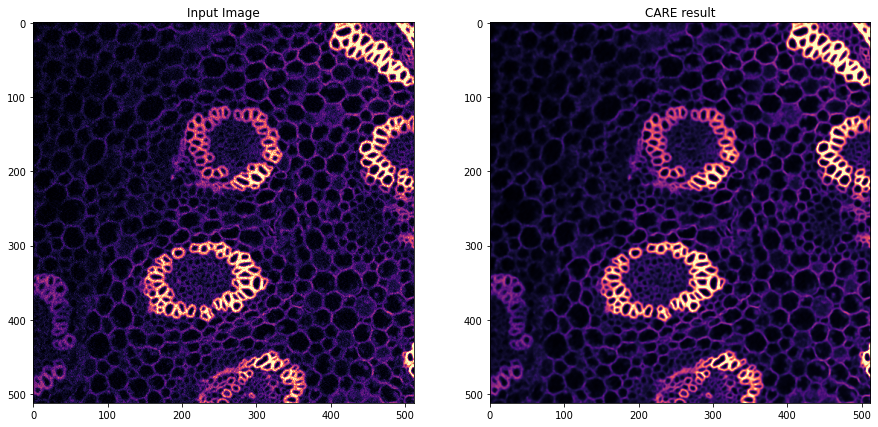

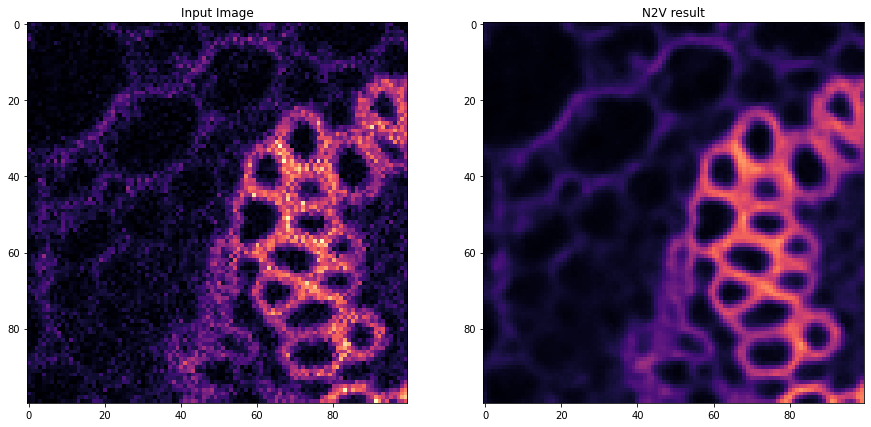

Avg PSNR CARE: 36.71881751994394 +-(2SEM) 0.008363166960761913


In [ ]:
# Now we are processing data and calculating PSNR values.
careRes=[]
resultImgs=[]
inputImgs=[]

# We iterate over all test images.
for index in range(dataTest.shape[0]):
    
    im=dataTest[index]
    gt=dataTestGT[0] # The ground truth is the same for all images
    
    # We are using tiling to fit the image into memory
    # If you get an error try a smaller patch size (ps)
    careResult = prediction.tiledPredict(im, net ,ps=256, overlap=48,
                                            device=device, noiseModel=None)
    
    
    inputImgs.append(im)

    rangePSNR=np.max(gt)-np.min(gt)
    carePrior=PSNR(gt, careResult,rangePSNR )
    careRes.append(carePrior)

    print ("image:",index)
    print ("PSNR input",PSNR(gt, im, rangePSNR))
    print ("PSNR CARE",carePrior) # Without info from masked pixel
    print ('-----------------------------------')
    
    
# We display the results for the last test image       
vmi=np.percentile(gt,0.01)
vma=np.percentile(gt,99)

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.title(label='Input Image')
plt.imshow(im, vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 2, 2)
plt.title(label='CARE result')
plt.imshow(careResult, vmax=vma, vmin=vmi, cmap='magma')

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.title(label='Input Image')
plt.imshow(im[100:200,150:250], vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 2, 2)
plt.title(label='CARE result')
plt.imshow(careResult[100:200,150:250], vmax=vma, vmin=vmi, cmap='magma')
plt.show()

print("Avg PSNR CARE:", np.mean(np.array(careRes) ), '+-(2SEM)',2*np.std(np.array(careRes) )/np.sqrt(float(len(careRes)) ) )

####BSD68

image: 1
PSNR input 19.297779631298447
PSNR CARE 14.840643147122169
-----------------------------------
image: 2
PSNR input 20.05669734056735
PSNR CARE 13.811003495188777
-----------------------------------
image: 3
PSNR input 18.872105207748955
PSNR CARE 9.2734462876148
-----------------------------------
image: 4
PSNR input 20.05669734056735
PSNR CARE 11.746222266744955
-----------------------------------
image: 5
PSNR input 20.19402651962569
PSNR CARE 11.795988469184822
-----------------------------------
image: 6
PSNR input 18.872105207748955
PSNR CARE 11.302760863215994
-----------------------------------
image: 7
PSNR input 19.37298260876458
PSNR CARE 14.492954626608437
-----------------------------------
image: 8
PSNR input 19.739530230555214
PSNR CARE 14.174723441329999
-----------------------------------
image: 9
PSNR input 18.990282399959362
PSNR CARE 14.637846517673527
-----------------------------------
image: 10
PSNR input 18.990282399959362
PSNR CARE 8.36825650616578
----

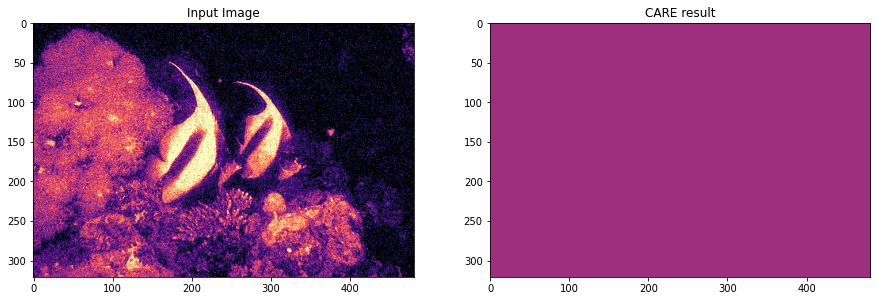

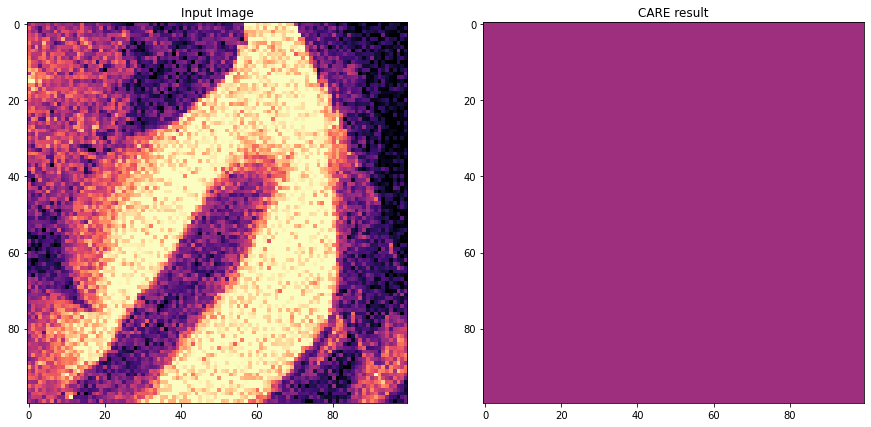

Avg PSNR CARE: 12.542446902778208 +-(2SEM) 0.5912998632300164


In [ ]:
# Now we are processing data and calculating PSNR values.
careRes=[]
resultImgs=[]
inputImgs=[]
index = 1
# We iterate over all test images.
for gt, im in zip(dataTestGT, dataTest): 
    
    #im=dataTest[index]
    #gt=dataTestGT[0] # The ground truth is the same for all images
    
    # We are using tiling to fit the image into memory
    # If you get an error try a smaller patch size (ps)
    careResult = prediction.tiledPredict(im, net ,ps=64, overlap=16,
                                            device=device, noiseModel=None)
    
    
    inputImgs.append(im)

    rangePSNR=np.max(gt)-np.min(gt)
    carePrior=PSNR(gt, careResult,rangePSNR )
    careRes.append(carePrior)

    print ("image:",index)
    print ("PSNR input",PSNR(gt, im, rangePSNR))
    print ("PSNR CARE",carePrior) # Without info from masked pixel
    print ('-----------------------------------')
    index +=1
    
# We display the results for the last test image       
vmi=np.percentile(gt,0.01)
vma=np.percentile(gt,99)

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.title(label='Input Image')
plt.imshow(im, vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 2, 2)
plt.title(label='CARE result')
plt.imshow(careResult, vmax=vma, vmin=vmi, cmap='magma')

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.title(label='Input Image')
plt.imshow(im[100:200,150:250], vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 2, 2)
plt.title(label='CARE result')
plt.imshow(careResult[100:200,150:250], vmax=vma, vmin=vmi, cmap='magma')
plt.show()

print("Avg PSNR CARE:", np.mean(np.array(careRes) ), '+-(2SEM)',2*np.std(np.array(careRes) )/np.sqrt(float(len(careRes)) ) )